In [21]:
import torch
from trainer.Model1 import UNet

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim import lr_scheduler
from torchvision import transforms

import numpy as np
import pandas as pd
from PIL import Image
import time

import librosa
import librosa.display

import matplotlib.pyplot as plt

import deepdish as dd
from multiprocessing import Pool, set_start_method

import utils

In [30]:
import warnings
warnings.simplefilter('ignore')

In [3]:
AUDIO_DIR = 'data/fma_small'
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

In [4]:
small_tracks = tracks[tracks['set', 'subset'] <= 'small']
small_genres = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

# Load preprocessed files

In [23]:
X = dd.io.load('data/fma_preprocessed/X_3.h5')
Y = dd.io.load('data/fma_preprocessed/Y_3.h5')

In [24]:
# Assuming files are preprocessed as image (256x256x3), labels are just strings
print(f'{"X":>31s}{"Y":>20s}')
print(f"Training:   {str(X['training'].shape):>20s}{str(Y['training'].shape):>20s}")
print(f"Validation: {str(X['validation'].shape):>20s}{str(Y['validation'].shape):>20s}")
print(f"Test:       {str(X['test'].shape):>20s}{str(Y['test'].shape):>20s}")

                              X                   Y
Training:   (19184, 1, 128, 128)          (19184, 8)
Validation:  (2400, 1, 128, 128)           (2400, 8)
Test:        (2400, 1, 128, 128)           (2400, 8)


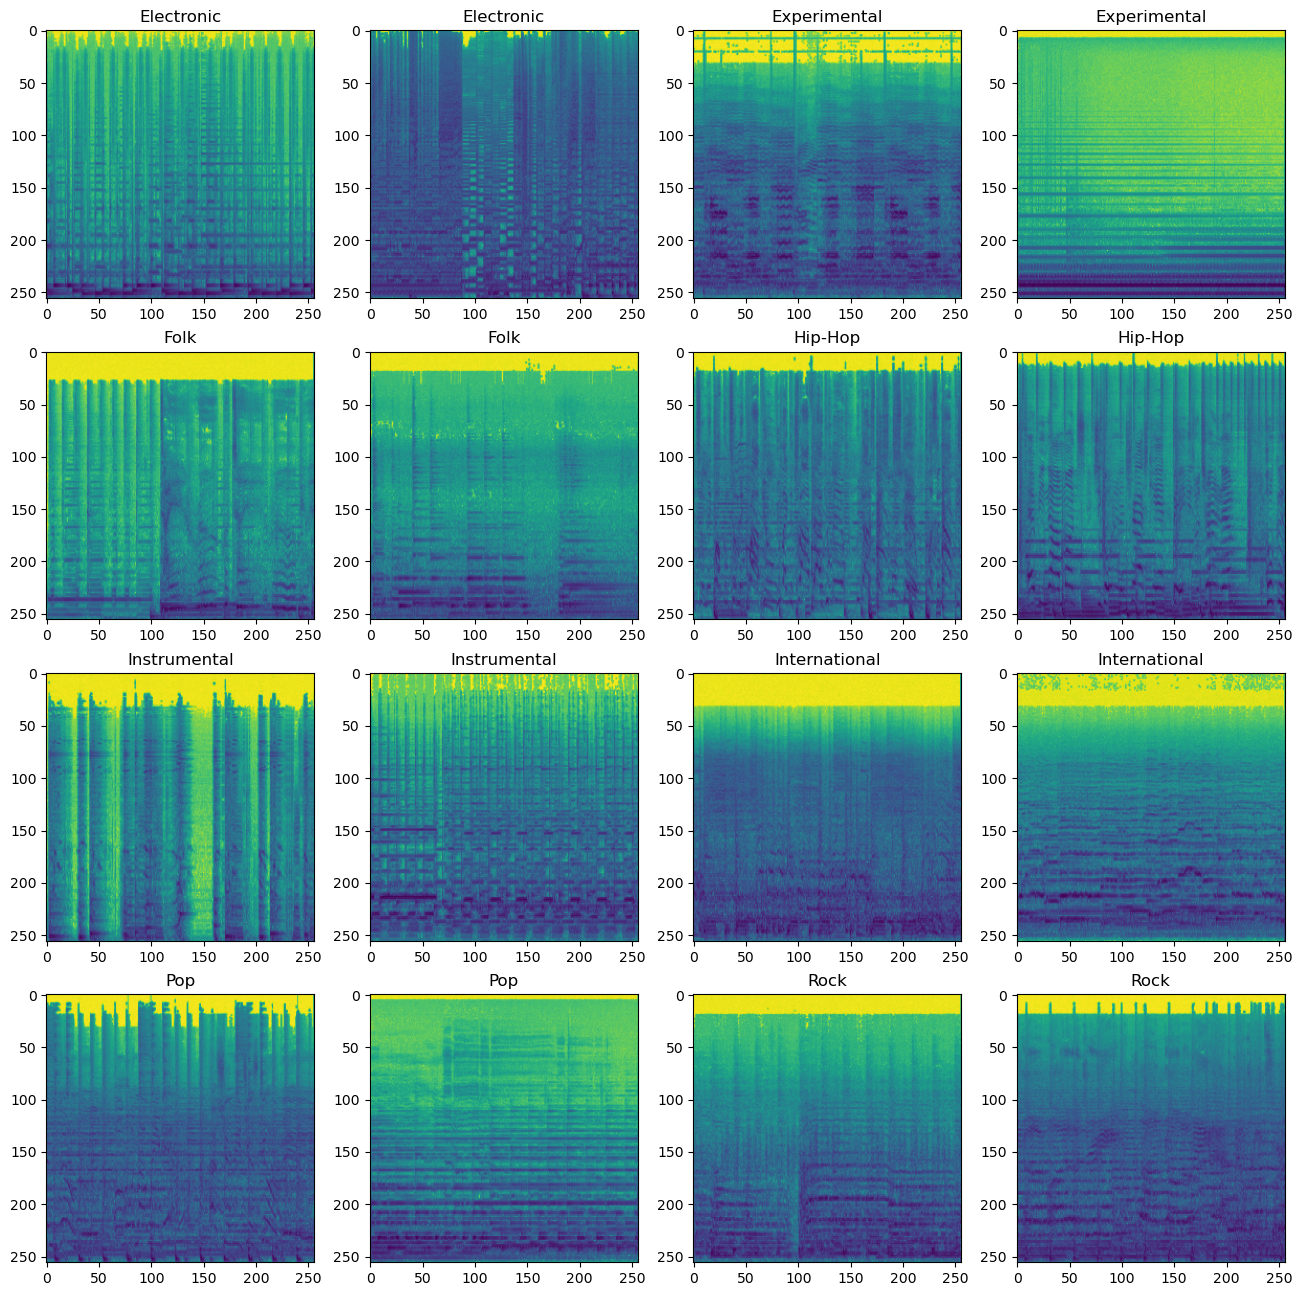

In [20]:
idx = (192, 345, 60, 75, 9, 63, 0, 93, 1182, 1566, 87, 129, 6, 48, 51, 72)

fig = plt.figure(figsize=(16, 16))

for i in range(len(idx)):
    ax = fig.add_subplot(4, 4, i+1)
    ai = idx[i]
    img = X['training'][ai]
    y = np.argmax(Y['training'][ai])
    ax.imshow(img.transpose(1,2,0))
    ax.set_title(small_genres[y])


## Define Dataset and Model classes

In [7]:
class FMADataset(Dataset):
    def __init__(self, mode='training'):
        if mode not in ('training', 'validation', 'test'):
            raise Error('mode must be training, validation, or test.')
        self.mode = mode
        self.x = X[mode]
        self.y = Y[mode]
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        # ndarray contains negative strides
        # to fix, we flip a copy, and flip again
        image = torch.from_numpy(np.flip(self.x[index], axis=0).astype('float64').copy())
        image = torch.flip(image, dims=(0,))
        label = self.y[index]
        return image.float(), label

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## First overfit on a single batch

Current model does not seem to be learning

In [9]:
# Use dotdict util to emulate argparse
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [33]:
import trainer
import importlib

from trainer.UNet import UNet
from trainer.RCNN import RCNN
from trainer.CNN import CNN
from trainer.CNN1 import CNN1

importlib.reload(trainer.UNet)
importlib.reload(trainer.RCNN)
importlib.reload(trainer.CNN)
importlib.reload(trainer.CNN1)

from trainer.UNet import UNet
from trainer.RCNN import RCNN
from trainer.CNN import CNN
from trainer.CNN1 import CNN1

args = {
    'learning_rate': 0.0001,
    'batch_size': 16,
    'num_epochs': 30,
    'job_directory': 'saved_models'
}
args = dotdict(args)

train_set = FMADataset(mode='training')
val_set = FMADataset(mode='validation')
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False)
model = UNet()
optim = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = None
# scheduler = lr_scheduler.OneCycleLR(
#     optim, 
#     max_lr=args.learning_rate, 
#     epochs=args.num_epochs,
#     steps_per_epoch=len(train_loader)
# )
# scheduler = lr_scheduler.ReduceLROnPlateau(optim, 'min')
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optim, 5)
loss_function = torch.nn.CrossEntropyLoss()
train_acc, val_acc = [], []
for ep in range(args.num_epochs):
    model.train()
    batch_train_acc, batch_val_acc = [],[]
    acc = 0.
    num_samples = 0.
    for i in range(5):
        start = time.time()
        xs, ys = next(iter(train_loader))
        xs, ys = xs.to(device), ys.to(device) 
        optim.zero_grad()
        probs = model(xs)
        
        ys = torch.max(ys, 1)[1]
        loss = loss_function(probs, ys)
        loss.backward()
        optim.step()
        
        pred = probs.cpu().argmax(1)
        acc += (pred == ys).sum()
        num_samples += ys.size(0)
        
        if scheduler is not None:
            scheduler.step(ep + i / len(train_loader))
        
        elapsed = time.time() - start
    
    acc /= num_samples
        
    print(f'Epoch {ep} Loss {loss.item():0.4f} Train Acc: {acc:0.4f}')
    
    model.eval()
    with torch.no_grad():
        pass

Epoch 0 Loss 2.6697 Train Acc: 0.1250
Epoch 1 Loss 2.5133 Train Acc: 0.1500
Epoch 2 Loss 2.0397 Train Acc: 0.1875
Epoch 3 Loss 2.3353 Train Acc: 0.2875
Epoch 4 Loss 2.0176 Train Acc: 0.2125
Epoch 5 Loss 2.1248 Train Acc: 0.1375
Epoch 6 Loss 1.9172 Train Acc: 0.2250
Epoch 7 Loss 1.9516 Train Acc: 0.3625
Epoch 8 Loss 2.1127 Train Acc: 0.2625
Epoch 9 Loss 2.1437 Train Acc: 0.3000
Epoch 10 Loss 2.1211 Train Acc: 0.3375
Epoch 11 Loss 2.1713 Train Acc: 0.3000
Epoch 12 Loss 2.1985 Train Acc: 0.2750
Epoch 13 Loss 2.6276 Train Acc: 0.2125
Epoch 14 Loss 1.6985 Train Acc: 0.2500
Epoch 15 Loss 1.6661 Train Acc: 0.3625
Epoch 16 Loss 2.0178 Train Acc: 0.2750
Epoch 17 Loss 2.2839 Train Acc: 0.2375


KeyboardInterrupt: 

In [37]:
xs, ys = next(iter(train_loader))
xs, ys = xs.to(device), ys.to(device) 
probs = model(xs)
pred = probs.cpu().argmax(1)
ys = torch.max(ys, 1)[1]
print(pred)
print(ys)
acc = (pred == ys.cpu()).sum().item()
print(acc)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5])
tensor([6, 7, 6, 2, 3, 3, 7, 3, 2, 2, 2, 5, 6, 7, 0, 7])
0


In [24]:
probs

tensor([[0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.4460e-44,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,

In [103]:
args = {
    'learning_rate': 0.001,
    'batch_size': 300,
    'num_epochs': 4,
    'job_directory': 'saved_models'
}

args = dotdict(args)

In [114]:
def fit(args):
    train_set = FMADataset(mode='training')
    val_set = FMADataset(mode='validation')
    
    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False)
    
    model = Net()
    optim = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    # scheduler = None
    scheduler = lr_scheduler.OneCycleLR(
        optim, 
        max_lr=args.learning_rate, 
        epochs=args.num_epochs,
        steps_per_epoch=len(train_loader)
    )
    loss_function = torch.nn.NLLLoss()
    
    # Keep track of metrics
    total_train_loss, total_val_loss = [], []
    
    print('Train Loss    Val Loss')
    for epoch in range(args.num_epochs):
        start = time.time() # Track elapsed time for training/validation
        model.train()
        for xs, ys in train_loader:
            xs, ys = xs.to(device), ys.to(device)
            
            optim.zero_grad()
            probs = model(xs)
            ys = torch.max(ys, 1)[1]
            loss = loss_function(probs, ys)
            
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            
            # Track metrics
            total_train_loss.append(loss.item())
            
        model.eval()
        with torch.no_grad():
            for xs, ys in val_loader:
                xs, ys = xs.to(device), ys.to(device)
                probs = model(xs)
                loss = loss_function(probs, ys)
                
                # Track metrics
                total_val_loss.append(loss.item())
                                      
        elapsed = time.time() - start
        print(f'{epoch:5d}{total_train_loss[-1]:14.4f}{total_val_loss[-1]:12.4f}')
        timer(elapsed)
    
    export_path = os.path.join(args.job_dir, 'test_model.pth')
    torch.save(model.state_dict(), export_path)